# Computer Vision Nanodegree

## Project: Image Captioning

---

In this notebook, you will use your trained model to generate captions for images in the test dataset.

This notebook **will be graded**.  

Feel free to use the links below to navigate the notebook:
- [Step 1](#step1): Get Data Loader for Test Dataset 
- [Step 2](#step2): Load Trained Models
- [Step 3](#step3): Finish the Sampler
- [Step 4](#step4): Clean up Captions
- [Step 5](#step5): Generate Predictions!

<a id='step1'></a>
## Step 1: Get Data Loader for Test Dataset

Before running the code cell below, define the transform in `transform_test` that you would like to use to pre-process the test images.  

Make sure that the transform that you define here agrees with the transform that you used to pre-process the training images (in **2_Training.ipynb**).  For instance, if you normalized the training images, you should also apply the same normalization procedure to the test images.

In [1]:
import sys
sys.path.append('/opt/cocoapi/PythonAPI')
# sys.path.append('/Users/lacfo/cocoapi/PythonAPI')
from pycocotools.coco import COCO
from data_loader import get_loader
from torchvision import transforms

# TODO #1: Define a transform to pre-process the testing images.
transform_test = transforms.Compose([ 
    transforms.Resize(256),                          # smaller edge of image resized to 256
    transforms.RandomCrop(224),                      # get 224x224 crop from random location            
    transforms.ToTensor(),                           # convert the PIL Image to a tensor
    transforms.Normalize((0.485, 0.456, 0.406),      # normalize image for pre-trained model
                         (0.229, 0.224, 0.225))])

#-#-#-# Do NOT modify the code below this line. #-#-#-#

# Create the data loader.
data_loader = get_loader(transform=transform_test,    
                         mode='test')

Vocabulary successfully loaded from vocab.pkl file!


Run the code cell below to visualize an example test image, before pre-processing is applied.

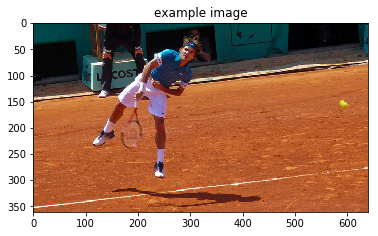

In [2]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# Obtain sample image before and after pre-processing.
orig_image, image = next(iter(data_loader))

# Visualize sample image, before pre-processing.
plt.imshow(np.squeeze(orig_image))
plt.title('example image')
plt.show()

<a id='step2'></a>
## Step 2: Load Trained Models

In the next code cell we define a `device` that you will use move PyTorch tensors to GPU (if CUDA is available).  Run this code cell before continuing.

In [3]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Before running the code cell below, complete the following tasks.

### Task #1

In the next code cell, you will load the trained encoder and decoder from the previous notebook (**2_Training.ipynb**).  To accomplish this, you must specify the names of the saved encoder and decoder files in the `models/` folder (e.g., these names should be `encoder-5.pkl` and `decoder-5.pkl`, if you trained the model for 5 epochs and saved the weights after each epoch).  

### Task #2

Plug in both the embedding size and the size of the hidden layer of the decoder corresponding to the selected pickle file in `decoder_file`.

In [4]:
# Watch for any changes in model.py, and re-load it automatically.
% load_ext autoreload
% autoreload 2

import os
import torch
from model import EncoderCNN, DecoderRNN

# TODO #2: Specify the saved models to load.
encoder_file = "encoder-4.pkl"
decoder_file = "decoder-4.pkl"

# TODO #3: Select appropriate values for the Python variables below.
embed_size = 256
hidden_size = 512

# The size of the vocabulary.
vocab_size = len(data_loader.dataset.vocab)

# Initialize the encoder and decoder, and set each to inference mode.
encoder = EncoderCNN(embed_size)
encoder.eval()
decoder = DecoderRNN(embed_size, hidden_size, vocab_size)
decoder.eval()

# Load the trained weights.
encoder.load_state_dict(torch.load(os.path.join('./models', encoder_file)))
decoder.load_state_dict(torch.load(os.path.join('./models', decoder_file)))

# Move models to GPU if CUDA is available.
encoder.to(device)
decoder.to(device)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.torch/models/resnet50-19c8e357.pth
100%|██████████| 102502400/102502400 [00:03<00:00, 32744790.18it/s]


DecoderRNN(
  (embedding): Embedding(9955, 256)
  (lstm): LSTM(256, 512, batch_first=True)
  (linear): Linear(in_features=512, out_features=9955, bias=True)
)

<a id='step3'></a>
## Step 3: Finish the Sampler

Before executing the next code cell, you must write the `sample` method in the `DecoderRNN` class in **model.py**.  This method should accept as input a PyTorch tensor `features` containing the embedded input features corresponding to a single image.

It should return as output a Python list `output`, indicating the predicted sentence.  `output[i]` is a nonnegative integer that identifies the predicted `i`-th token in the sentence.  The correspondence between integers and tokens can be explored by examining either `data_loader.dataset.vocab.word2idx` (or `data_loader.dataset.vocab.idx2word`).

After implementing the `sample` method, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.  Do **not** modify the code in the cell below. 

In [5]:
# Move image Pytorch Tensor to GPU if CUDA is available.
image = image.to(device)

# Obtain the embedded image features.
features = encoder(image).unsqueeze(1)

# Pass the embedded image features through the model to get a predicted caption.
output = decoder.sample(features)

assert (type(output)==list), "Output needs to be a Python list" 
assert all([type(x)==int for x in output]), "Output should be a list of integers." 
assert all([x in data_loader.dataset.vocab.idx2word for x in output]), "Each entry in the output needs to correspond to an integer that indicates a token in the vocabulary."

<a id='step4'></a>
## Step 4: Clean up the Captions

In the code cell below, complete the `clean_sentence` function.  It should take a list of integers (corresponding to the variable `output` in **Step 3**) as input and return the corresponding predicted sentence (as a single Python string). 

In [6]:
# TODO #4: Complete the function.
def clean_sentence(output):
    sentence = ""
    first = 1
    for i in output:
        if first:
            sentence += data_loader.dataset.vocab.idx2word[i]
            first = 0
        else:
            sentence += " " + data_loader.dataset.vocab.idx2word[i]
    return sentence

After completing the `clean_sentence` function above, run the code cell below.  If the cell returns an assertion error, then please follow the instructions to modify your code before proceeding.

In [7]:
sentence = clean_sentence(output)
print('example sentence:', sentence)

assert type(sentence)==str, 'Sentence needs to be a Python string!'

example sentence: <start> a man of a on a on a . <end> <end> . <end> . <end> . <end> . <end>


<a id='step5'></a>
## Step 5: Generate Predictions!

In the code cell below, we have written a function (`get_prediction`) that you can use to use to loop over images in the test dataset and print your model's predicted caption.

In [8]:
def get_prediction():
    orig_image, image = next(iter(data_loader))
    plt.imshow(np.squeeze(orig_image))
    plt.title('Sample Image')
    plt.show()
    image = image.to(device)
    features = encoder(image).unsqueeze(1)
    output = decoder.sample(features)    
    print(output)
    sentence = clean_sentence(output)
    print(sentence)

Run the code cell below (multiple times, if you like!) to test how this function works.

In [9]:
orig_image, image = next(iter(data_loader))

In [10]:
image = image.to(device)

In [19]:
features1 = encoder(image)

In [11]:
orig_image, image = next(iter(data_loader))

In [12]:
image = image.to(device)

In [13]:
features2 = encoder(image)

In [21]:
features1 == features2

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
          0,  0,  0,  0, 

In [22]:
features1 = features1.unsqueeze(1)
features2 = features2.squeeze(1)

In [26]:
features2 = features2.squeeze(2)

In [28]:
features2 = features2.unsqueeze(1)

In [37]:
features1

tensor([[[ 1818.1677,  -870.8971, -1048.7263, -1712.4370,  -283.7089,
            485.6036,  -480.8119,  -287.0837, -2269.9126,   665.5660,
            477.8162,   773.0905,  -476.4240,   -14.9799,   596.3450,
            750.4064,  -101.4126,   424.4278,   785.1705,  -482.1755,
            738.0387, -1344.8788,   -13.8991, -1554.9270,  -244.7834,
            974.1524,  -874.4480,    46.6004,  -236.7639,   363.1666,
            729.6403, -1563.8230,  -921.6942,  -428.6602,  -475.3755,
           1064.7324,  -657.9720, -1371.2030,    46.6041,  -828.8545,
           -541.4960,   415.4221,   -65.0033,   501.8831,  1547.0337,
            605.6608,   811.3779,   496.3465,  -687.2919,   162.0907,
            240.4324,  1326.4965,   989.2353, -1178.2205,  -863.7418,
          -1459.8693,  -686.8460,  -842.4814,    45.3999,  -347.3981,
           -738.5905,   -92.7759,   832.4962,   404.1069,   829.8052,
           1079.6826,  -875.5004,  -834.0001,   578.6887,  -105.7625,
            375.0211

In [38]:
features2

tensor([[[ 2396.7043, -1150.9594, -1176.8666, -2257.3745,  -387.0016,
            529.0429,  -687.2962,  -518.7741, -3164.2849,  1007.3309,
            605.2578,  1075.7483,  -593.4366,   -54.2204,   788.5995,
            950.8759,   -35.8230,   555.3445,  1065.7808,  -620.7817,
            959.0261, -1791.5299,   -58.4388, -2039.2643,  -300.2999,
           1455.8663, -1236.5665,   104.7787,  -282.0717,   519.2447,
           1051.5227, -2242.8367, -1350.1659,  -525.8958,  -586.0419,
           1404.0171,  -910.8758, -1780.9418,    -2.0852, -1136.7372,
           -809.6754,   479.3521,  -106.3627,   559.7306,  2009.7227,
            876.6152,  1144.8320,   645.4998,  -957.4801,   283.9899,
            228.7348,  1734.8542,  1387.5635, -1513.0160, -1079.9138,
          -1977.2852,  -936.4270, -1034.2429,    35.6292,  -659.4941,
           -953.7662,  -117.0158,  1126.7880,   476.0157,  1184.7581,
           1324.7460, -1215.8231, -1232.5737,   879.4554,  -197.9538,
            459.0488

In [11]:
output1 = decoder.sample(features1)

NameError: name 'features1' is not defined

In [36]:
output2 = decoder.sample(features2)

tensor([[[ 0.0000,  0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.7616,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000, -0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
           0.0000,  0.0000,  0.0000,  0.0000, -0.76

tensor([[[ 1.2610e-12,  4.2253e-15, -3.3596e-09, -1.7839e-10,  9.2398e-15,
           3.1070e-21,  5.6274e-13, -2.4641e-15,  1.2083e-10, -1.7523e-19,
          -5.7824e-13, -1.7106e-10,  2.0619e-13,  2.3965e-14, -7.7332e-12,
           2.2505e-17, -1.3721e-05,  2.6771e-05,  6.1556e-07, -2.7169e-16,
           5.4812e-11, -1.7817e-11,  5.6953e-05, -7.9493e-15,  1.4171e-09,
           4.2676e-04, -3.9752e-13, -2.1763e-13,  8.2164e-08, -1.1157e-11,
           7.5248e-14,  8.9511e-14, -6.9999e-12,  1.8784e-16,  2.2823e-10,
           6.4774e-15,  2.1621e-10,  2.6377e-09,  2.9954e-06, -1.8502e-14,
          -4.2087e-17,  4.3406e-10, -3.4087e-11, -6.1162e-16,  6.2886e-12,
           6.7728e-10,  5.5232e-12, -1.5387e-13, -4.8843e-15, -2.6771e-14,
          -1.1711e-06, -2.4016e-15, -3.3435e-04, -1.2922e-14,  1.9291e-13,
           1.0734e-06,  1.6379e-14, -1.0811e-09,  1.4530e-04, -1.4011e-08,
           1.9517e-07, -1.9074e-12,  9.2201e-05, -2.0316e-14, -1.6373e-02,
           2.2088e-20,  4

In [30]:
output1 == output2

True

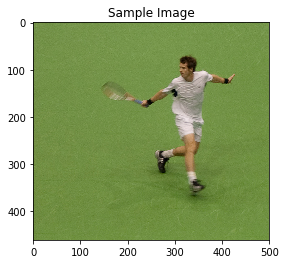

torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
torch.Size([1, 256])
[0, 3, 169, 13, 3, 39, 3, 39, 3, 18, 1, 1, 18, 1, 18, 1, 18, 1, 18, 1]
<start> a man of a on a on a . <end> <end> . <end> . <end> . <end> . <end>


In [16]:
get_prediction()

As the last task in this project, you will loop over the images until you find four image-caption pairs of interest:
- Two should include image-caption pairs that show instances when the model performed well.
- Two should highlight image-caption pairs that highlight instances where the model did not perform well.

Use the four code cells below to complete this task.

### The model performed well!

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively accurate captions.

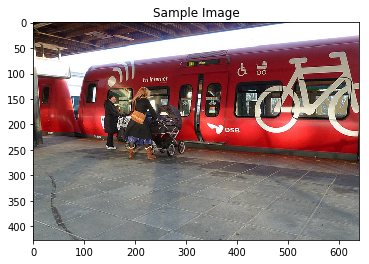

[0, 3, 169, 13, 3, 39, 3, 39, 3, 18, 1, 1, 18, 1, 18, 1, 18, 1, 18, 1]
<start> a man of a on a on a . <end> <end> . <end> . <end> . <end> . <end>


In [13]:
get_prediction()

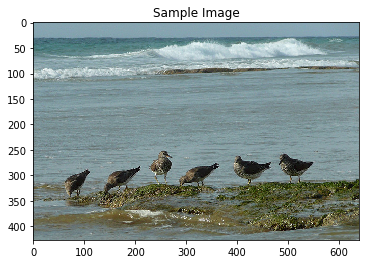

[0, 3, 169, 13, 3, 39, 3, 39, 3, 18, 1, 1, 18, 1, 18, 1, 18, 1, 18, 1]
<start> a man of a on a on a . <end> <end> . <end> . <end> . <end> . <end>


In [14]:
get_prediction()

### The model could have performed better ...

Use the next two code cells to loop over captions.  Save the notebook when you encounter two images with relatively inaccurate captions.

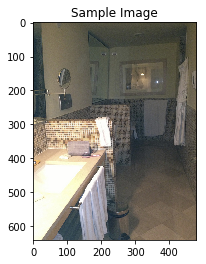

[0, 3, 169, 13, 3, 39, 3, 39, 3, 18, 1, 1, 18, 1, 18, 1, 18, 1, 18, 1]
<start> a man of a on a on a . <end> <end> . <end> . <end> . <end> . <end>


In [15]:
get_prediction()

In [ ]:
get_prediction()